## Check GPU

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-981912e7-585f-49c2-1ad9-600372b88670)


In [2]:
# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

TensorFlow version: 2.10.0
Notebook last run (end-to-end): 2023-07-29 13:50:57.359582


## Get helper functions

In [3]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")


[INFO] 'helper_functions.py' already exists, skipping download.


## Download Kaggle dataset

In [4]:
!pip install opendatasets

In [5]:
import opendatasets as od
import pandas as pd

In [6]:
# Download data from Kaggle
od.download("https://www.kaggle.com/datasets/saloni1712/chatgpt-app-reviews")

Skipping, found downloaded files in ".\chatgpt-app-reviews" (use force=True to force download)


In [7]:
data = pd.read_csv('C:/Users/Nima/Desktop/ChatGPT_Reviews/chatgpt-app-reviews/chatgpt_reviews.csv')

In [8]:
data.shape

(2058, 4)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2058 non-null   object
 1   title   2058 non-null   object
 2   review  2058 non-null   object
 3   rating  2058 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 64.4+ KB


In [10]:
data.describe()

,rating
count,2058.000000
mean,3.744898
std,1.577841
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [11]:
data.describe(include='object')

,date,title,review
count,2058,2058,2058
unique,2053,1850,2033
top,2023-05-18 23:04:43,Finally,First
freq,2,13,5


## Analysis of Rating column

In [12]:
#Rating Distribution
data['rating'].value_counts().sort_index()

1     391
2     115
3     199
4     276
5    1077
Name: rating, dtype: int64

In [13]:
data['rating'].value_counts(normalize=True).mul(100).round(2).sort_index()

1    19.00
2     5.59
3     9.67
4    13.41
5    52.33
Name: rating, dtype: float64

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

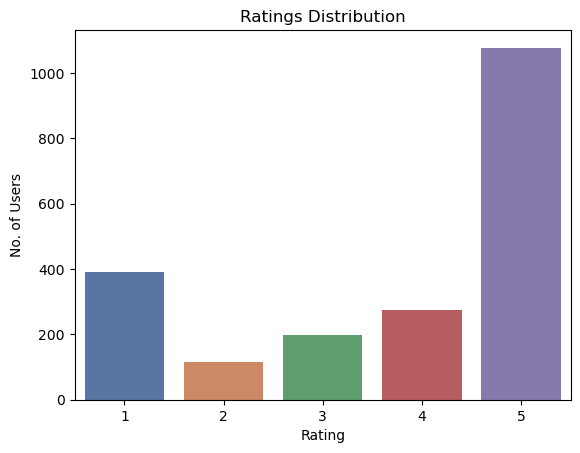

In [15]:
#Plot
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='rating')

plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

plt.show()

## Data Preprocessing

In [16]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

date      0
title     0
review    0
rating    0
dtype: int64

In [17]:
#Combine Review Time and Review
data['complete_review'] = data['title'] +' .'+data['review']

In [18]:
#Drop some columns which we won't use for sentiment analysis of review
remove_cols = ['date','review','title']
data = data.drop(remove_cols,axis='columns')

In [19]:
data.head()

,rating,complete_review
0,4,Much more accessible for blind users than the ...
1,4,"4.5 stars, here’s why .I recently downloaded t..."
2,4,"Almost 5 stars, but… no search function .This ..."
3,4,"Good, but Siri support would take it to the ne..."
4,1,"App review .No doubt, this technology is absol..."


#### Convert all the reviews to lowercase

In [20]:
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['complete_review'].head()

0    much more accessible for blind users than the ...
1    4.5 stars, here’s why .i recently downloaded t...
2    almost 5 stars, but… no search function .this ...
3    good, but siri support would take it to the ne...
4    app review .no doubt, this technology is absol...
Name: complete_review, dtype: object

#### Remove Punctuation

In [21]:
data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')

C:\Users\Nima\AppData\Local\Temp\ipykernel_2456\3606737599.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')


#### Remove Emojis

In [22]:
import re

In [23]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['complete_review'] = data['complete_review'].apply(lambda x: remove_emoji(x))

#### Remove Stopwords

In [24]:
# Instal spaCy: https://spacy.io/usage
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

  Obtaining dependency information for wheel from https://files.pythonhosted.org/packages/17/11/f139e25018ea2218aeedbedcf85cd0dd8abeed29a38ac1fda7f5a8889382/wheel-0.41.0-py3-none-any.whl.metadata
  Using cached wheel-0.41.0-py3-none-any.whl.metadata (2.2 kB)
Using cached wheel-0.41.0-py3-none-any.whl (64 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.38.4
    Uninstalling wheel-0.38.4:
      Successfully uninstalled wheel-0.38.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.0 requires libclang>=13.0.0, which is not installed.
tensorflow 2.10.0 requires tensorflow-io-gcs-filesystem>=0.23.1, which is not installed.
tensorboard 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 640.0 kB/s eta 0:00:20
     ---------------------------------------- 0.1/12.8 MB 1.3 MB/s eta 0:00:10
     ---------------------------------------- 0.2/12.8 MB 1.3 MB/s eta 0:00:10
      --------------------------------------- 0.2/12.8 MB 1.3 MB/s eta 0:00:11
      --------------------------------------- 0.3/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.4/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.4/12.8 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.5/12.8 MB 1.3 MB/s eta 0:00:10
     - -------------------------------------- 0.5/12.8 MB 1.2 MB/s eta 0:00:11
     - -------------------------------------- 0.5/12.8 MB 1.1 MB/s eta 0:00:11
     - -------------------------------------- 0.6/12.8 MB 1.1 MB/s eta 0:00:11
     - -------------------------------------- 0.6/12.8 MB 

In [25]:
import nltk
from nltk.corpus import stopwords
import spacy

In [26]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
# nlp = spacy.load('en_core_web_sm')

In [28]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [29]:
stop = stopwords.words('english')
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#### Apply Lemmatization

In [30]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['complete_review']= data['complete_review'].apply(space)

#### Remove certain words

In [31]:
words_to_remove = ['chatgpt','app','chatgpts','chat','gpt','iphone','ipad','gpt4','phone','number','ai','use','io']
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

#### **Map ratings to positive, negative & neutral sentiment**

0 will represent negative sentiment

1 will represent neutral sentiment

2 will represent positive sentiment

In [32]:
data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.head(5)

,rating,complete_review,sentiment
0,4,much accessible blind user web version point I...,2
1,4,45 star here recently download overall great p...,2
2,4,almost 5 star search function would almost per...,2
3,4,good siri support would take next level apprec...,2
4,1,review doubt technology absolutely lifechange ...,0


In [33]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

2    65.74
0    24.59
1     9.67
Name: sentiment, dtype: float64

## Reviews Analysis

In [34]:
!pip install wordcloud

In [35]:
from wordcloud import WordCloud, STOPWORDS

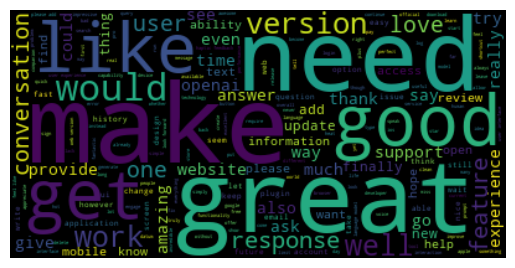

In [36]:
#Analysis of Review field
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [37]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

In [38]:
positive.shape, negative.shape, neutral.shape

((1353, 3), (506, 3), (199, 3))

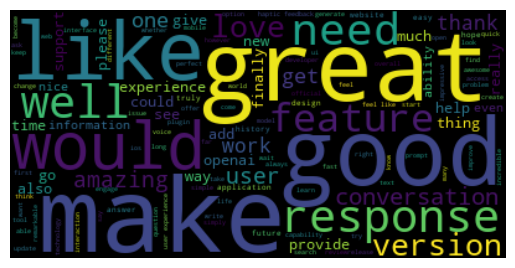

In [39]:
#Positive Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in positive.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

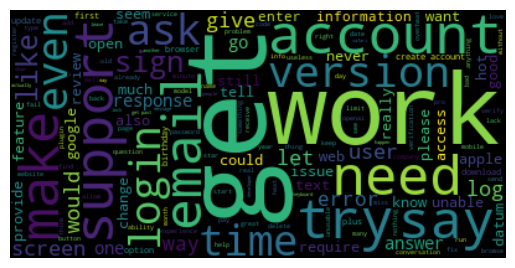

In [40]:
#Negative Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in negative.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

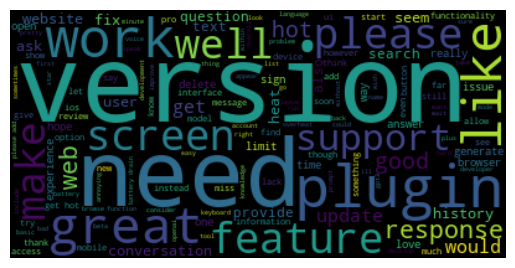

In [41]:
#Neutral Sentiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in neutral.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Bag of Word Vectorization

In [42]:
#from nltk.tokenize import RegexpTokenizer
#from sklearn.feature_extraction.text import CountVectorizer

In [43]:
# Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
#token = RegexpTokenizer(r'[a-zA-Z0-9]+')
#cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
#X = cv.fit_transform(data['complete_review'])
#y = data['sentiment']

#### Handle Imbalanced Data

In [44]:
#from imblearn.over_sampling import SMOTE

In [45]:
# Instantiate the SMOTE object
#smote = SMOTE()

# Perform oversampling
#X_oversampled, y_oversampled = smote.fit_resample(X, y)

## Train Test Split

In [46]:
from sklearn.model_selection import train_test_split

#Train Test split
X_train, X_test, y_train, y_test = train_test_split(data['complete_review'],
                                                   data['sentiment'],
                                                   test_size=0.15,
                                                   random_state=42,
                                                   stratify=data['sentiment'])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1749,)
(1749,)
(309,)
(309,)


In [47]:
# View the first 10 training sentences and their labels
X_train[:10], y_train[:10]

(1736                                                     
 1067    30 great issue do not knowledge past september...
 1407                                      slow stuck time
 298     work quickly type fast goal model conversation...
 1945                                                 love
 728     complaint version please would love see versio...
 1335    will not work title say freeze will not work d...
 1601    nice shogoth nice please do not bite promise i...
 360     good start like gimme siri apple ecosystem int...
 1013    everyone know fantastic achievement daily plea...
 Name: complete_review, dtype: object,
 1736    2
 1067    2
 1407    0
 298     0
 1945    2
 728     2
 1335    0
 1601    2
 360     2
 1013    1
 Name: sentiment, dtype: int64)

#### Split data into training and validation sets

In [48]:
## Changed to data, we can aslo data['somplete_review'] or data['sentiment']

# Shuffle training dataframe
train_df_shuffled = data.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,rating,complete_review,sentiment
1298,1,log apple account log official website can not...,0
591,4,first message ios store well must say first ve...,2
1318,5,truthgpt elon musk sam altman truthgpt also go...,2
1067,4,30 great issue do not knowledge past september...,2
29,5,cuttingedge conversation pocket write gamechan...,2


In [49]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df_shuffled)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["complete_review", "sentiment"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"sentiment: {target}", "(Negative)" if target == 0 else "(Neutral)" if target == 1 else "(Positive)")
  print(f"complete_review:\n{text}\n")
  print("---\n")

sentiment: 2 (Positive)
complete_review:
good smart help think good

---

sentiment: 0 (Negative)
complete_review:
sign issue can not sign do not know every time say face suspicious behaviour please openai fix issue

---

sentiment: 2 (Positive)
complete_review:
awsome good buy nowadays

---

sentiment: 1 (Neutral)
complete_review:
compatibility iosipado old version hello thank hard work we ios 15 ipado 15 deny could please make compatible old version iosipado thank

---

sentiment: 2 (Positive)
complete_review:
gamechanger assistance lifechanging experience would understatement call great thing ever happen always whether I m attempt difficult vehicle repair troubleshoot computer issue delve programming code seem speak foreign language contrast platform bing less constrain intuitive ability provide straightforward precise instruction solution language precise comprehensible truly remarkable addition assistance troubleshooting code I ve discover infinite application serve assistant guid

In [50]:
train_df_shuffled["complete_review"].shape

(2058,)

In [51]:
## Changed train_df_shuffled["complete_review"] and train_df_shuffled["sentiment"]

#from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
#train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["complete_review"].to_numpy(),
#                                                                            train_df_shuffled["sentiment"].to_numpy(),
#                                                                            test_size=0.20, # dedicate 10% of samples to validation set
#                                                                            random_state=42) # random state for reproducibility

In [52]:
# Check the lengths
#len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

## Converting text into numbers (tokenization)

In [53]:
import numpy as np
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6

# Before TensorFlow 2.6
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [54]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

21

In [55]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 21 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)


In [56]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [57]:
# Create sample sentence and tokenize it
sample_sentence = "Amazing, I like ChatGPT app!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 21), dtype=int64, numpy=
array([[35,  4,  5,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0]], dtype=int64)>

In [58]:
# Choose a random sentence from the training dataset and tokenize it
import random
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
amazing many stupid store amazing find official one release one feature nobody talk voice dictation I m basically write entire review I m speak naturally get everything transcribe perfectly great work really well two issue first rotate kind dumb fine secondly there s version kind sad web okay firstclass like great please keep updating do not forget keep awesome support bluetooth external keyboards big correction version full effect awesome      

Vectorized version:


<tf.Tensor: shape=(1, 21), dtype=int64, numpy=
array([[  35,  129,  722,  251,   35,   76,   83,   25,  150,   25,   20,
        1587,  244,   93,  755,    4,   22,  704,   88,  644,   60]],
      dtype=int64)>

In [59]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 4963
Top 5 most common words: ['', '[UNK]', 'not', 'make', 'i']
Bottom 5 least common words: ['14pm', '140', '128', '06192023', '0']


## **Creating an Embedding using an Embedding Layer**

In [60]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [61]:
# Get a random sentence from training set
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
less love ui design clean practical do not like download knock becuase make pay either annoying ad make widget website home page easy access work fine official elegant still google deep research whenever random question need simple answer bunch article I m always go first thank guy wait patiently guy put recommend sibling      

Embedded version:


<tf.Tensor: shape=(1, 21, 128), dtype=float32, numpy=
array([[[-0.0456783 , -0.02594477, -0.02107209, ..., -0.02108103,
         -0.03948566,  0.02279476],
        [-0.0360391 ,  0.04377549, -0.02435933, ...,  0.01564142,
          0.01607269,  0.01678478],
        [ 0.00530003, -0.00156077, -0.02801371, ..., -0.04780035,
         -0.00250208, -0.03335661],
        ...,
        [-0.0458313 ,  0.03027562, -0.02847349, ..., -0.03056868,
          0.00205125, -0.01531418],
        [-0.0299324 , -0.0030354 ,  0.02131907, ...,  0.04517749,
          0.04456357, -0.03643613],
        [ 0.03621639,  0.00904629, -0.02893016, ..., -0.00658573,
         -0.00547973,  0.0088869 ]]], dtype=float32)>

In [62]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.0456783 , -0.02594477, -0.02107209,  0.0148272 , -0.01752386,
        0.04353995, -0.01737996,  0.02706822, -0.01237813,  0.02336866,
       -0.04892662,  0.01009705,  0.00354639,  0.02085856,  0.02194326,
        0.00052471, -0.04637427,  0.01126492,  0.0064665 ,  0.00817202,
        0.01447013,  0.03047868,  0.03886812,  0.0404449 , -0.00782943,
        0.02473173,  0.02453668, -0.04681108, -0.02637843,  0.01335916,
        0.00395196,  0.02596824, -0.03601432,  0.03731788,  0.03928962,
        0.00633925, -0.01645903, -0.01596627, -0.01551536, -0.00793995,
       -0.02942047,  0.02545407, -0.0438487 ,  0.0200377 , -0.01219677,
       -0.03955871,  0.03995172, -0.00928231,  0.04868552,  0.0158494 ,
       -0.02684095,  0.00374239, -0.03556461,  0.04327036,  0.04444666,
       -0.04645814,  0.02050123, -0.04262675, -0.04593626,  0.02200908,
        0.00525962,  0.00131933, -0.00320814, -0.02478736, -0.01044011,
       -0.011291

## **Creating an evaluation function for our model experiments**

* Accuracy
* Precision
* Recall
* F1-score

In [63]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

## **Modelling a text dataset**

* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

#### Model 0: Getting a baseline

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [65]:
# baseline_score = model_0.score(val_sentences, val_labels)
baseline_score = model_0.score(X_test, y_test)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 71.84%


In [66]:
# Make predictions
baseline_preds = model_0.predict(X_test)
baseline_preds[:50]

array([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int64)

In [67]:
# Get baseline results
baseline_results = calculate_results(y_true = y_test,
                                     y_pred = baseline_preds)

baseline_results

{'accuracy': 71.84466019417476,
 'precision': 0.6663351363482191,
 'recall': 0.7184466019417476,
 'f1': 0.6468889962130967}

#### Model 1: A simple dense model

In [68]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [69]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(3, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [70]:
# Compile model
model_1.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 21)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,280,387
Trainable params: 1,280,387
N

In [72]:
# Fit the model
model_1_history = model_1.fit(X_train, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              y_train,
                              epochs=5,
                              validation_data=(X_test, y_test),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230729-135134
Epoch 1/5
55/55 [==============================] - 1s 8ms/step - loss: 0.9666 - accuracy: 0.6581 - val_loss: 0.8597 - val_accuracy: 0.6667
Epoch 2/5
55/55 [==============================] - 0s 5ms/step - loss: 0.8041 - accuracy: 0.6821 - val_loss: 0.7762 - val_accuracy: 0.6861
Epoch 3/5
55/55 [==============================] - 0s 5ms/step - loss: 0.7176 - accuracy: 0.7130 - val_loss: 0.7157 - val_accuracy: 0.6958
Epoch 4/5
55/55 [==============================] - 0s 5ms/step - loss: 0.6383 - accuracy: 0.7496 - val_loss: 0.6686 - val_accuracy: 0.7346
Epoch 5/5
55/55 [==============================] - 0s 5ms/step - loss: 0.5714 - accuracy: 0.7799 - val_loss: 0.6376 - val_accuracy: 0.7476


In [73]:
# Check the results
model_1.evaluate(X_test, y_test)

10/10 [==============================] - 0s 1ms/step - loss: 0.6376 - accuracy: 0.7476


[0.6375741958618164, 0.7475728392601013]

In [74]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-0.00359972,  0.0682437 ,  0.003753  , ..., -0.11141181,
          0.03723739, -0.02487089],
        [ 0.03304552, -0.00065037,  0.00814508, ...,  0.04940203,
          0.0198375 , -0.01627664],
        [-0.17410187,  0.04019051, -0.20630357, ..., -0.10520159,
         -0.14441247, -0.12597664],
        ...,
        [-0.03797395, -0.03102829, -0.02514763, ...,  0.02949489,
          0.0267799 ,  0.04535898],
        [-0.01279204, -0.02901628,  0.04653472, ..., -0.02827383,
         -0.02623067,  0.00933105],
        [-0.01939325,  0.04736057, -0.0459506 , ...,  0.0093045 ,
          0.01711787, -0.02156491]], dtype=float32)>]

In [75]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [76]:
## View tensorboard logs of transfer learning modelling experiments (should be 4 models)
## Upload TensorBoard dev records
#!tensorboard --version
#!tensorboard dev upload --logdir ./model_logs \
#--name "First deep model on text data" \
#--description "Trying a dense model with an embedding layer" \
#--one_shot # exits the uploader when upload has finished

In [77]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

In [78]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(X_test)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

10/10 [==============================] - 0s 778us/step


array([[0.4710536 , 0.1911878 , 0.7322504 ],
       [0.3524746 , 0.18790665, 0.80079204],
       [0.40845233, 0.18368867, 0.7750182 ],
       [0.39618826, 0.18565778, 0.780377  ],
       [0.70547986, 0.2779974 , 0.50731647],
       [0.40215632, 0.20307007, 0.7621084 ],
       [0.43486413, 0.34018162, 0.66273   ],
       [0.50661266, 0.24921699, 0.6737523 ],
       [0.24478611, 0.26977158, 0.8161829 ],
       [0.350439  , 0.20194407, 0.7908207 ]], dtype=float32)

In [79]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [80]:
model_1_preds.shape

TensorShape([309, 3])

In [81]:
# Convert one-hot coding to single-digit ones
model_1_preds_sngd =np.argmax(model_1_preds, axis=1)
model_1_preds_sngd

array([2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2,
       2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0,
       0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2,

In [82]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=y_test, 
                                    y_pred=model_1_preds_sngd)
model_1_results

{'accuracy': 77.99352750809061,
 'precision': 0.6996344846039201,
 'recall': 0.7799352750809061,
 'f1': 0.7343390162327382}

In [83]:
# Is our simple Keras model better than our baseline model?
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

In [84]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 71.84, New accuracy: 77.99, Difference: 6.15
Baseline precision: 0.67, New precision: 0.70, Difference: 0.03
Baseline recall: 0.72, New recall: 0.78, Difference: 0.06
Baseline f1: 0.65, New f1: 0.73, Difference: 0.09


## Recurrent Neural Networks (RNN's)

#### Model 2: LSTM

In [85]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(3, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 21, 128)
(None, 64)


In [86]:
# Compile model
model_2.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [87]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 21)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,329,603
Trainable params: 1,329,603
Non-trainable params: 0
____________________________________________

In [88]:
# Fit model
model_2_history = model_2.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_test, y_test),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230729-135137
Epoch 1/5
55/55 [==============================] - 2s 19ms/step - loss: 0.8518 - accuracy: 0.6518 - val_loss: 0.7233 - val_accuracy: 0.7249
Epoch 2/5
55/55 [==============================] - 1s 11ms/step - loss: 0.5622 - accuracy: 0.7919 - val_loss: 0.5879 - val_accuracy: 0.7799
Epoch 3/5
55/55 [==============================] - 1s 11ms/step - loss: 0.3972 - accuracy: 0.8519 - val_loss: 0.6518 - val_accuracy: 0.7476
Epoch 4/5
55/55 [==============================] - 1s 12ms/step - loss: 0.2946 - accuracy: 0.8856 - val_loss: 0.8185 - val_accuracy: 0.7540
Epoch 5/5
55/55 [==============================] - 1s 11ms/step - loss: 0.2369 - accuracy: 0.9200 - val_loss: 0.8695 - val_accuracy: 0.7508


In [89]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(X_test)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

10/10 [==============================] - 0s 3ms/step


((309, 3),
 array([[0.43172002, 0.45957798, 0.57027465],
        [0.13892004, 0.07933515, 0.9743424 ],
        [0.38603675, 0.27619252, 0.7730151 ],
        [0.15170714, 0.08596276, 0.96947545],
        [0.9861606 , 0.29663172, 0.10782868],
        [0.2991352 , 0.29256257, 0.7970579 ],
        [0.9596117 , 0.40826926, 0.0984659 ],
        [0.48895305, 0.30965337, 0.68874145],
        [0.13563275, 0.0785185 , 0.9753697 ],
        [0.13945231, 0.07991921, 0.97397476]], dtype=float32))

In [90]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [91]:
# Convert one-hot coding to single-digit ones
model_2_preds_sngd =np.argmax(model_2_preds, axis=1)
model_2_preds_sngd

array([2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2,
       2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0,
       1, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2,
       2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2,
       2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1,
       0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1,
       2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       0, 2, 2, 0, 0, 2, 2, 0, 1, 2, 1, 2, 2, 2, 0,

In [92]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=y_test,
                                    y_pred=model_2_preds_sngd)
model_2_results

{'accuracy': 76.69902912621359,
 'precision': 0.7422853014786782,
 'recall': 0.7669902912621359,
 'f1': 0.7515017143561433}

In [93]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 71.84, New accuracy: 76.70, Difference: 4.85
Baseline precision: 0.67, New precision: 0.74, Difference: 0.08
Baseline recall: 0.72, New recall: 0.77, Difference: 0.05
Baseline f1: 0.65, New f1: 0.75, Difference: 0.10


#### Model 3: GRU

In [94]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(3, activation="sigmoid")(x) # try exponential as well
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [95]:
# Compile GRU model
model_3.compile(loss="SparseCategoricalCrossentropy", # if your labels are integer form (not one hot) use SparseCategoricalCrossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [96]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 21)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,317,443
Trainable params: 1,317,443
Non-trainable params: 0
_____________________________________________

In [97]:
# Fit model
model_3_history = model_3.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_test, y_test),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230729-135143
Epoch 1/5
55/55 [==============================] - 2s 20ms/step - loss: 0.8939 - accuracy: 0.6375 - val_loss: 0.8424 - val_accuracy: 0.6570
Epoch 2/5
55/55 [==============================] - 1s 13ms/step - loss: 0.7649 - accuracy: 0.6747 - val_loss: 0.7500 - val_accuracy: 0.7055
Epoch 3/5
55/55 [==============================] - 1s 18ms/step - loss: 0.5044 - accuracy: 0.8056 - val_loss: 0.6318 - val_accuracy: 0.7573
Epoch 4/5
55/55 [==============================] - 1s 13ms/step - loss: 0.3776 - accuracy: 0.8525 - val_loss: 0.6852 - val_accuracy: 0.7443
Epoch 5/5
55/55 [==============================] - 1s 13ms/step - loss: 0.3112 - accuracy: 0.8839 - val_loss: 0.7646 - val_accuracy: 0.7508


In [98]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(X_test)
model_3_pred_probs.shape, model_3_pred_probs[:10]

10/10 [==============================] - 0s 3ms/step


((309, 3),
 array([[0.41799012, 0.38253433, 0.6864723 ],
        [0.14995305, 0.12587821, 0.9795116 ],
        [0.18086284, 0.15783355, 0.9652506 ],
        [0.16083537, 0.13508181, 0.9754493 ],
        [0.89320993, 0.63598996, 0.05533807],
        [0.2647146 , 0.24659064, 0.8987978 ],
        [0.5395598 , 0.54777443, 0.4445026 ],
        [0.4390816 , 0.39935467, 0.65072674],
        [0.18312463, 0.15812168, 0.9646414 ],
        [0.17678761, 0.15570737, 0.9668641 ]], dtype=float32))

In [99]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 1., 0.],
       [0., 0., 1.],
       [1., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [100]:
# Convert one-hot coding to single-digit ones
model_3_preds_sngd =np.argmax(model_3_preds, axis=1)
model_3_preds_sngd

array([2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0,
       0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2,
       0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2,

In [101]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=y_test, 
                                    y_pred=model_3_preds_sngd)
model_3_results

{'accuracy': 74.75728155339806,
 'precision': 0.6718039242311087,
 'recall': 0.7475728155339806,
 'f1': 0.7073468341867966}

In [102]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 71.84, New accuracy: 74.76, Difference: 2.91
Baseline precision: 0.67, New precision: 0.67, Difference: 0.01
Baseline recall: 0.72, New recall: 0.75, Difference: 0.03
Baseline f1: 0.65, New f1: 0.71, Difference: 0.06


#### Model 4: Bidirectonal RNN model

In [103]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(3, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [104]:
# Compile
model_4.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [105]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 21)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,379,203
Trainable params: 1,3

In [107]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_test, y_test),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230729-135253
Epoch 1/5
55/55 [==============================] - 1s 15ms/step - loss: 0.1487 - accuracy: 0.9537 - val_loss: 1.0223 - val_accuracy: 0.6634
Epoch 2/5
55/55 [==============================] - 1s 15ms/step - loss: 0.1170 - accuracy: 0.9640 - val_loss: 1.1925 - val_accuracy: 0.7055
Epoch 3/5
55/55 [==============================] - 1s 15ms/step - loss: 0.0930 - accuracy: 0.9720 - val_loss: 1.1715 - val_accuracy: 0.6990
Epoch 4/5
55/55 [==============================] - 1s 15ms/step - loss: 0.0853 - accuracy: 0.9720 - val_loss: 1.3558 - val_accuracy: 0.7152
Epoch 5/5
55/55 [==============================] - 1s 15ms/step - loss: 0.0847 - accuracy: 0.9737 - val_loss: 1.5751 - val_accuracy: 0.7055


In [108]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(X_test)
model_4_pred_probs[:10]

10/10 [==============================] - 0s 3ms/step


array([[0.58441603, 0.19084354, 0.6921398 ],
       [0.03746849, 0.11475737, 0.9903512 ],
       [0.7715749 , 0.10244232, 0.6253234 ],
       [0.10486331, 0.1984975 , 0.9543167 ],
       [0.99835426, 0.21549156, 0.00417204],
       [0.2067733 , 0.35450146, 0.8487295 ],
       [0.216087  , 0.8941336 , 0.30113697],
       [0.40624243, 0.1753392 , 0.82806355],
       [0.00626611, 0.09408064, 0.99816114],
       [0.0149026 , 0.10110438, 0.9962383 ]], dtype=float32)

In [109]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[1., 0., 1.],
       [0., 0., 1.],
       [1., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [110]:
# Convert one-hot coding to single-digit ones
model_4_preds_sngd = np.argmax(model_4_preds, axis=1)
model_4_preds_sngd

array([0, 2, 0, 2, 0, 2, 1, 2, 2, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 2, 0, 0,
       2, 2, 0, 2, 0, 2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0,
       1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0,
       2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0,
       0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 0, 0, 2, 0, 2, 2,
       2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 0, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0,
       0, 2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 0,

In [111]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(y_true=y_test, 
                                    y_pred=model_4_preds_sngd)
model_4_results

{'accuracy': 64.72491909385113,
 'precision': 0.6613632000438813,
 'recall': 0.6472491909385113,
 'f1': 0.6438407290102576}

In [112]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 71.84, New accuracy: 64.72, Difference: -7.12
Baseline precision: 0.67, New precision: 0.66, Difference: -0.00
Baseline recall: 0.72, New recall: 0.65, Difference: -0.07
Baseline f1: 0.65, New f1: 0.64, Difference: -0.00


## Convolutional Neural Networks for Text

#### Model 5: Conv1D

In [113]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 21, 128]), TensorShape([1, 17, 32]), TensorShape([1, 32]))

In [114]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 21, 128), dtype=float32, numpy=
 array([[[ 0.03304552, -0.00065037,  0.00814508, ...,  0.04940203,
           0.0198375 , -0.01627664],
         [ 0.03304552, -0.00065037,  0.00814508, ...,  0.04940203,
           0.0198375 , -0.01627664],
         [ 0.04253047,  0.04206963,  0.03741383, ..., -0.06837944,
           0.02087741,  0.06434504],
         ...,
         [-0.00359972,  0.0682437 ,  0.003753  , ..., -0.11141181,
           0.03723739, -0.02487089],
         [-0.00359972,  0.0682437 ,  0.003753  , ..., -0.11141181,
           0.03723739, -0.02487089],
         [-0.00359972,  0.0682437 ,  0.003753  , ..., -0.11141181,
           0.03723739, -0.02487089]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 17, 32), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.06771053, 0.09836944, 0.        ,
          0.04416813, 0.04237713, 0.01627339, 0.        , 0.06238744,
          0.00783806, 0.        , 0.        , 0.        , 0.05843347,
          0.02286935, 0.

In [115]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(3, activation="softmax")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="SparseCategoricalCrossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 21)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 21, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 3)              

In [116]:
# Fit the model
model_5_history = model_5.fit(X_train,
                              y_train,
                              epochs=5,
                              validation_data=(X_test, y_test),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230729-135305
Epoch 1/5
55/55 [==============================] - 1s 8ms/step - loss: 0.8889 - accuracy: 0.6575 - val_loss: 0.8186 - val_accuracy: 0.6570
Epoch 2/5
55/55 [==============================] - 0s 5ms/step - loss: 0.7297 - accuracy: 0.7038 - val_loss: 0.6626 - val_accuracy: 0.7540
Epoch 3/5
55/55 [==============================] - 0s 6ms/step - loss: 0.5446 - accuracy: 0.7919 - val_loss: 0.6042 - val_accuracy: 0.7702
Epoch 4/5
55/55 [==============================] - 0s 6ms/step - loss: 0.4021 - accuracy: 0.8508 - val_loss: 0.6107 - val_accuracy: 0.7670
Epoch 5/5
55/55 [==============================] - 0s 6ms/step - loss: 0.2921 - accuracy: 0.9034 - val_loss: 0.6603 - val_accuracy: 0.7638


In [117]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(X_test)
model_5_pred_probs[:10]

10/10 [==============================] - 0s 1ms/step


array([[0.24849379, 0.15887563, 0.5926305 ],
       [0.00130217, 0.0093247 , 0.9893731 ],
       [0.01090218, 0.02584391, 0.96325386],
       [0.01271577, 0.027937  , 0.95934725],
       [0.9546432 , 0.03853577, 0.00682095],
       [0.02049434, 0.06655183, 0.91295385],
       [0.21221782, 0.29703888, 0.49074325],
       [0.24797548, 0.19432984, 0.5576946 ],
       [0.00462028, 0.04760051, 0.94777924],
       [0.00738704, 0.03107645, 0.96153647]], dtype=float32)

In [118]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [119]:
# Convert one-hot coding to single-digit ones
model_5_preds_sngd = np.argmax(model_5_preds, axis=1)
model_5_preds_sngd

array([2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,

In [120]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=y_test, 
                                    y_pred=model_5_preds_sngd)
model_5_results

{'accuracy': 77.02265372168284,
 'precision': 0.6906576996507824,
 'recall': 0.7702265372168284,
 'f1': 0.7257743180073277}

In [121]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 71.84, New accuracy: 77.02, Difference: 5.18
Baseline precision: 0.67, New precision: 0.69, Difference: 0.02
Baseline recall: 0.72, New recall: 0.77, Difference: 0.05
Baseline f1: 0.65, New f1: 0.73, Difference: 0.08


### Using Pretrained Embeddings (transfer learning for NLP)

#### Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [122]:
#!pip install --upgrade tensorflow_hub

In [123]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[ 0.02079362 -0.01668879  0.02163016 -0.03017881  0.01718219  0.02885695
  0.02265842 -0.01374736  0.04233807 -0.0039199  -0.01670229  0.00823712
 -0.01767393 -0.00255292 -0.06266202  0.07847117  0.00980331 -0.04035457
 -0.04608169 -0.01950894 -0.05638548 -0.03734807  0.0204862   0.01175738
 -0.02333322  0.10898352 -0.02122616  0.01536742 -0.00048371 -0.02942197
  0.02297653 -0.01020747  0.06413364 -0.02705132 -0.04650861  0.01735731
 -0.06472636  0.0197473  -0.00100798 -0.00867071  0.053029    0.02546862
  0.0209032   0.02089114 -0.01436865  0.06102893 -0.06005531  0.06909903
  0.06135271 -0.00263848], shape=(50,), dtype=float32)


In [124]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

#### **Multinomial Naive Bayes**

In [125]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

In [126]:
#Training the model
MNB = MultinomialNB()
MNB.fit(X_res_train, y_res_train)

#Caluclating the accuracy score of the model
y_pred = MNB.predict(X_res_test)
print(classification_report(y_pred, y_res_test))

NameError: name 'X_res_train' is not defined

#### **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

#### **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize and train the random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
print(classification_report(y_pred, y_test))

#### **XGBoost**

In [ ]:
import xgboost as xgb

In [ ]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Set the objective function for multi-class classification
    'num_class': 3,      # Number of classes in the dataset
    'eval_metric': 'merror',        # Evaluation metric (multi-class classification error rate)
    'eta': 0.4,                    # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of features when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(classification_report(pred_labels, y_test))

In [ ]:
# Create DMatrix for training and testing data
dtrain = xgb.DMatrix(X_res_train, label=y_res_train)
dtest = xgb.DMatrix(X_res_test, label=y_res_test)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Set the objective function for multi-class classification
    'num_class': 3,      # Number of classes in the dataset
    'eval_metric': 'merror',        # Evaluation metric (multi-class classification error rate)
    'eta': 0.4,                    # Learning rate
    'max_depth': 6,                # Maximum depth of a tree
    'subsample': 0.8,              # Subsample ratio of the training instances
    'colsample_bytree': 0.8,       # Subsample ratio of features when constructing each tree
    'seed': 42                     # Random seed for reproducibility
}

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the testing data
preds = model.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(classification_report(pred_labels, y_res_test))